#  Investigate the domain-wide surface Ba increase

In [2]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts

In [3]:
import glob
import datetime
import scipy.io
import scipy.signal
import numpy as np
import netCDF4 as nc
import cartopy.feature
import cartopy.crs as ccrs # ccrs
#import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [4]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [5]:
def seasonal_cycle(data):
    out = np.empty([12, np.size(data, 1), np.size(data, 2)])
    for mon in range(12):
        out[mon, :, :] = np.nanmean(data[mon:len(data):12, :, :], 0)
    return out
def seasonal_decomp3d(data):
    anom = np.empty(data.shape)
    for mon in range(12):
        temp_data = np.nanmean(data[mon:len(data):12, :, :], 0)
        anom[mon:len(data):12, :, :] = data[mon:len(data):12, :, :]-temp_data
    return anom

In [6]:
MAT = scipy.io.loadmat('_data/Exchange/AO_inds.mat')
upper_ind = MAT['upper_index'][:]
lower_ind = MAT['lower_index'][:]
AO_index = MAT['AO_index'][:]

In [7]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_1m_20020101_20131231_ptrc_T.nc'

In [8]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][:, 0, :, :])
d18O = np.squeeze(ptrc_obj.variables['d18O'][:, 0, :, :])
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [9]:
Ba[Ba==0]=np.nan
Ba_anom = seasonal_decomp3d(Ba)
Ba_monmean = seasonal_cycle(Ba)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [10]:
upper_Ba = Ba_anom[np.squeeze(upper_ind), :, :]
lower_Ba = Ba_anom[np.squeeze(lower_ind), :, :]

In [11]:
mean_upper_Ba = np.nanmean(upper_Ba, 0)
mean_lower_Ba = np.nanmean(lower_Ba, 0)

# Domain-wide increase pattern

In [12]:
lev1 = np.arange(30, 85, 5)

In [13]:
def draw_Ba(nav_lon, nav_lat, Ba, lev, ax, cmap=cm.GMT_haxby_r):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(nav_lon, nav_lat)
    CS=proj.contourf(x, y, Ba, lev, cmap=cmap, extend='both')
    proj.contour(x, y, Ba, lev, linewidths=0.5, colors=('gray',))
    return CS

(1, 144)

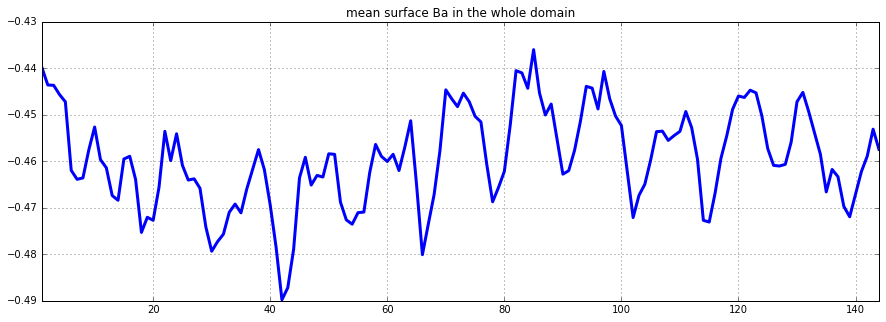

In [14]:
# polynomial curve fitting
x = np.arange(1, 145); y = np.nanmean(np.nanmean(d18O, 1), 1)
pf = np.polyfit(x, y, 2)
fun = np.poly1d(pf)
y0 = fun(x)
fig = plt.figure(figsize=(15, 5))
ax = fig.gca(); ax.grid()
ax.plot(x, y, 'b-', lw=3)
#ax.plot(x, y0, 'k--', lw=2)
ax.set_title('mean surface Ba in the whole domain')
ax.set_xlim([1, 144])

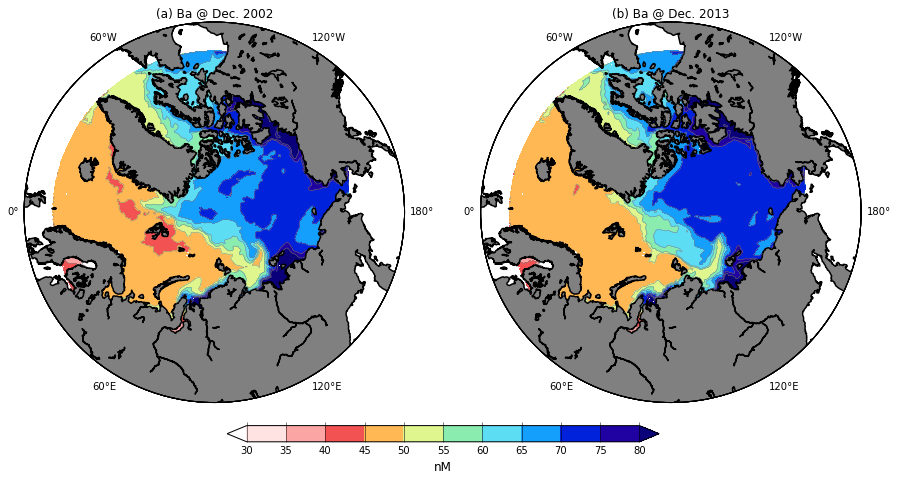

In [15]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

CS = draw_Ba(nav_lon, nav_lat, Ba[11, :, :], lev1, ax1)
draw_Ba(nav_lon, nav_lat, Ba[-1, :, :], lev1, ax2)

ax1.set_title('(a) Ba @ Dec. 2002')
ax2.set_title('(b) Ba @ Dec. 2013')

cax = fig.add_axes([0.313, 0.3, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('nM', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(lev1)

# The mean picture of each month

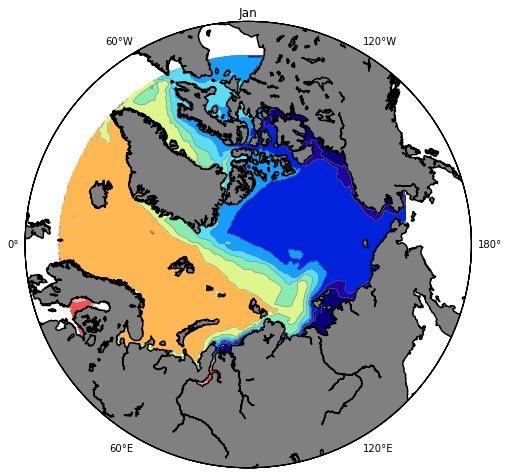

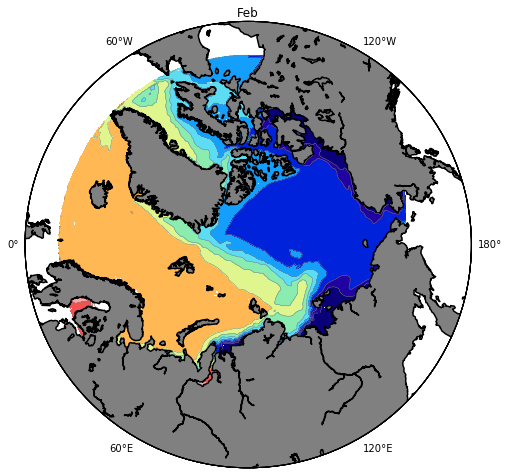

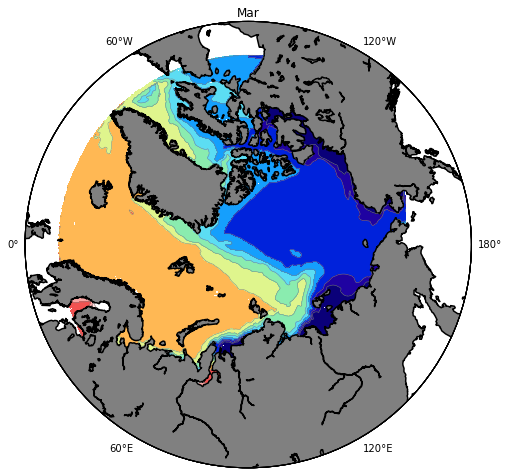

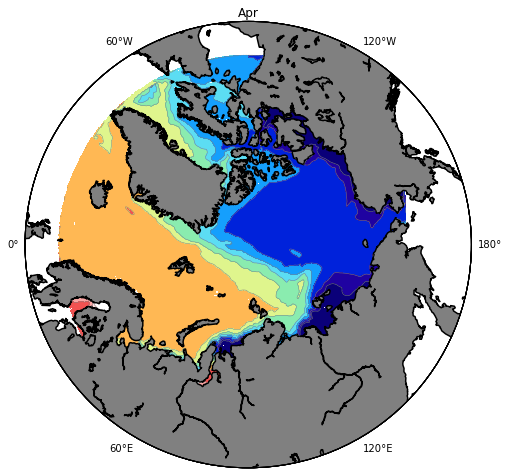

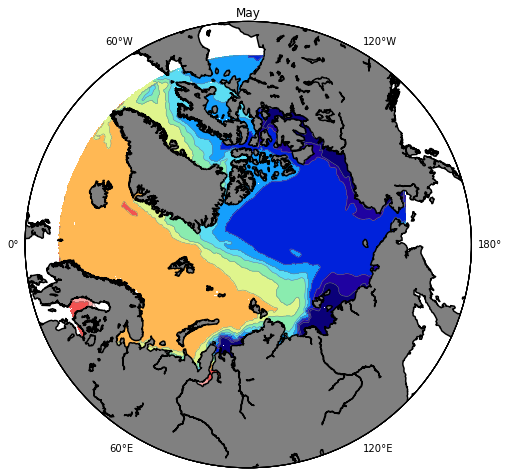

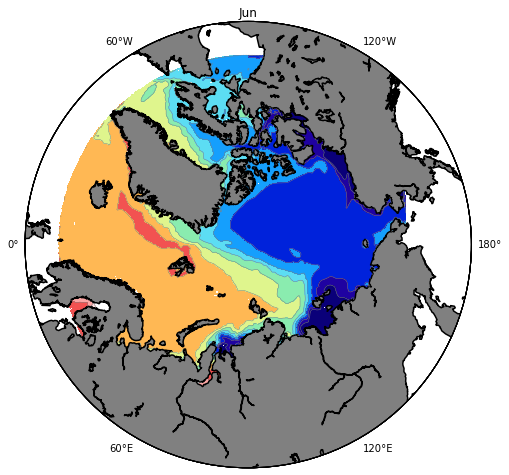

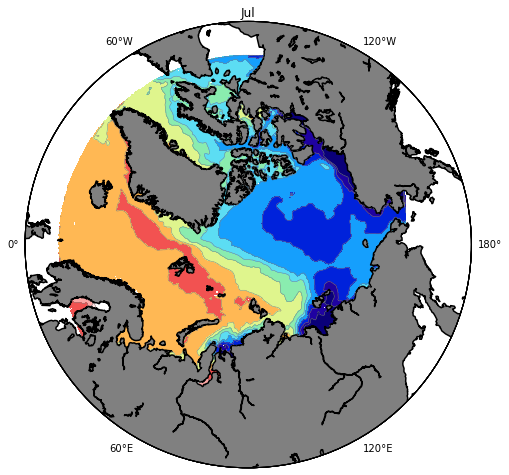

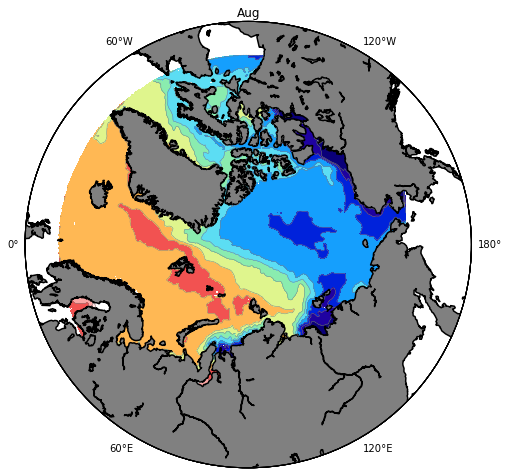

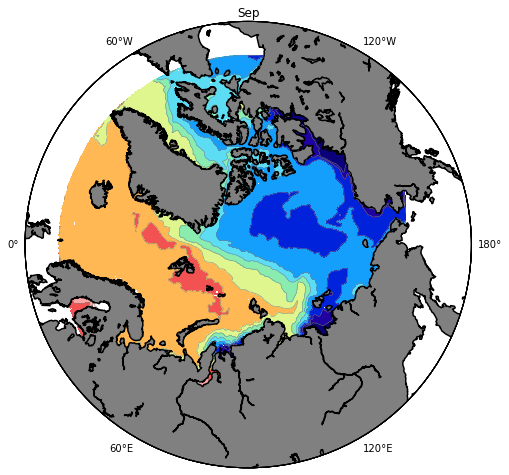

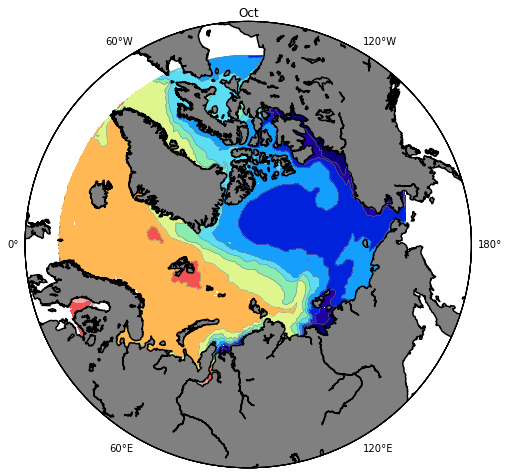

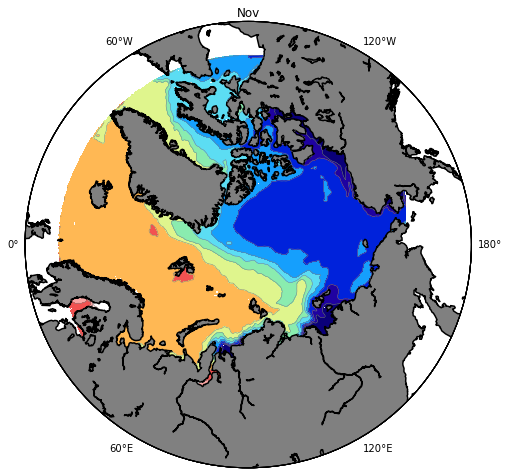

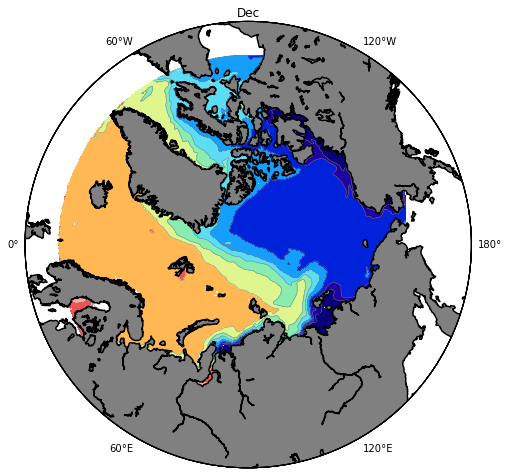

In [16]:
mon_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(12):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    CS = draw_Ba(nav_lon, nav_lat, Ba_monmean[i, :, :], lev1, ax)
    ax.set_title(mon_name[i])

# The anomaly in positive/negative AO phases

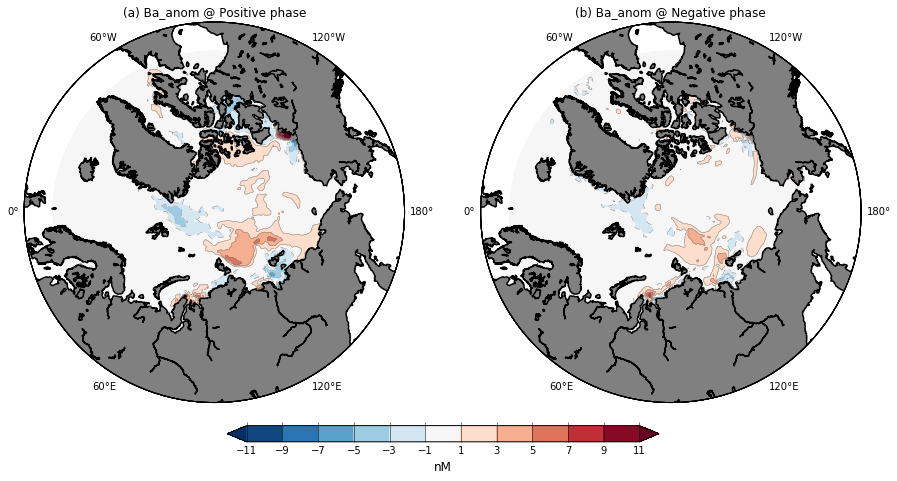

In [18]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

ax1.set_title('(a) Ba_anom @ Positive phase')
ax2.set_title('(b) Ba_anom @ Negative phase')

clevs = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])

CS = draw_Ba(nav_lon, nav_lat, mean_upper_Ba[:, :], clevs, ax1, cmap=plt.cm.RdBu_r)
draw_Ba(nav_lon, nav_lat, mean_lower_Ba[:, :], clevs, ax2, cmap=plt.cm.RdBu_r)

cax = fig.add_axes([0.313, 0.3, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('nM', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(clevs)

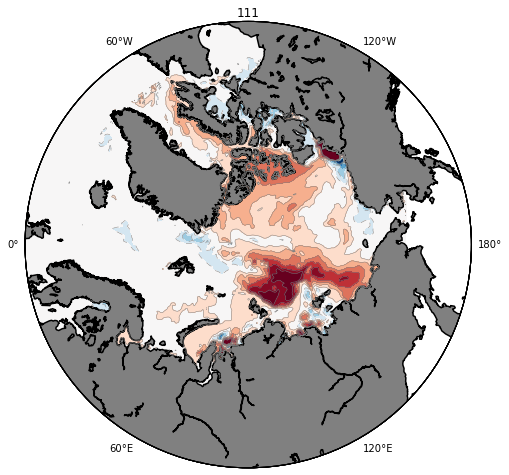

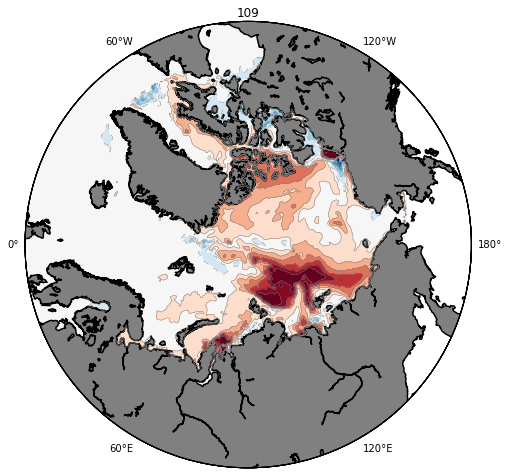

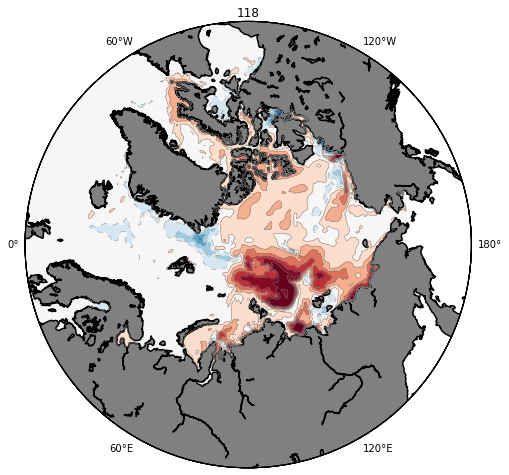

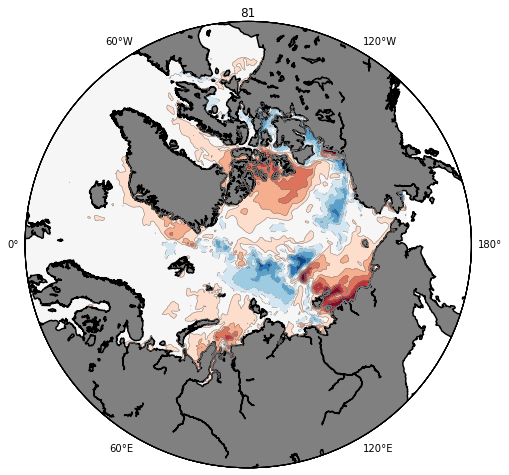

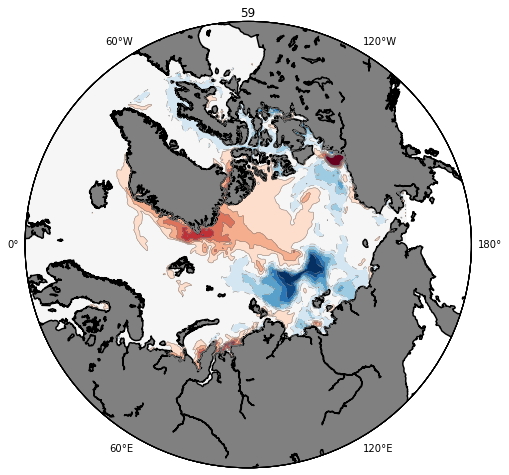

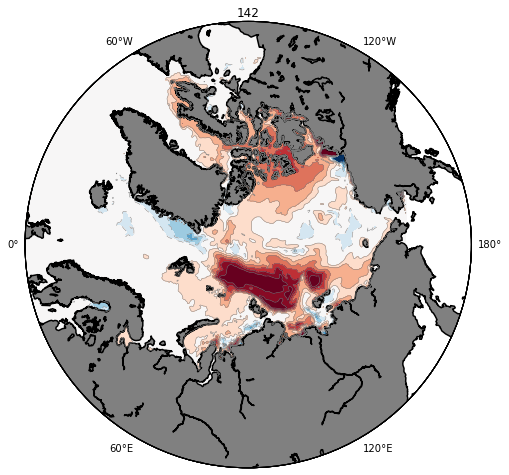

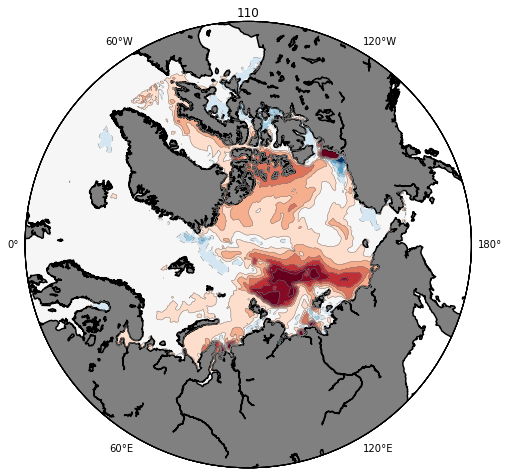

In [118]:
#for i in range(7):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    CS = draw_Ba(nav_lon, nav_lat, upper_Ba[i, :, :], clevs, ax, cmap=plt.cm.RdBu_r)
    ax.set_title(str(np.squeeze(upper_ind)[i]))

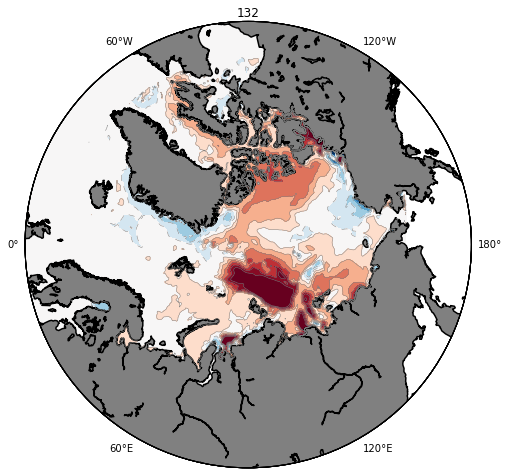

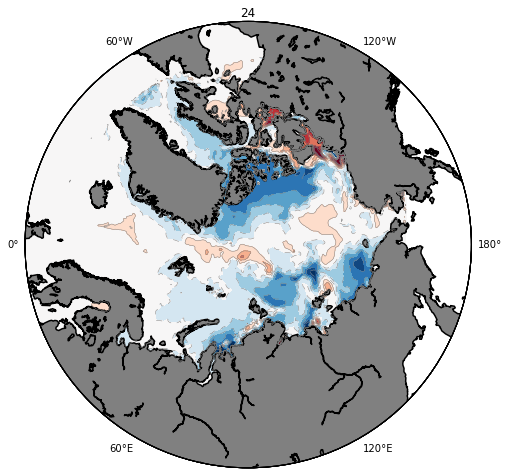

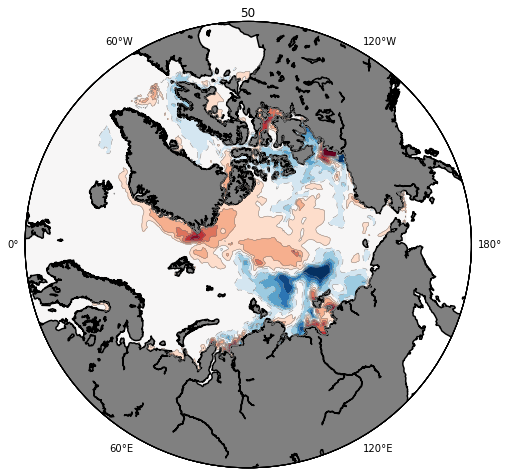

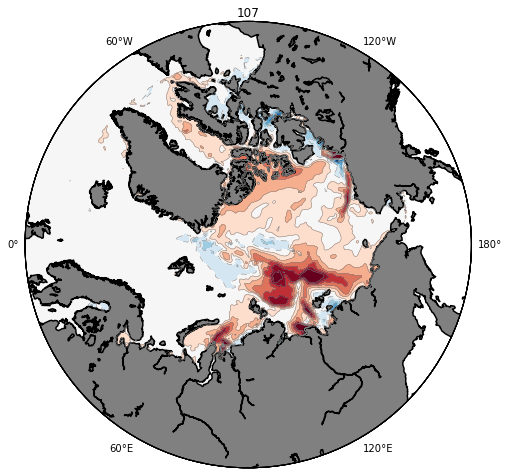

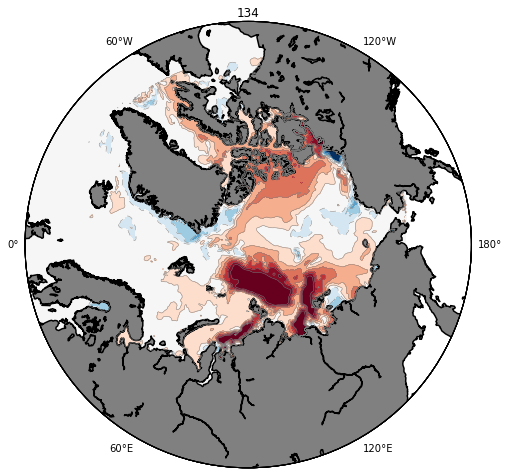

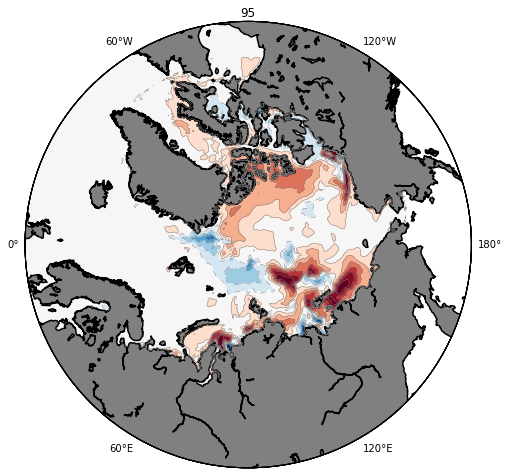

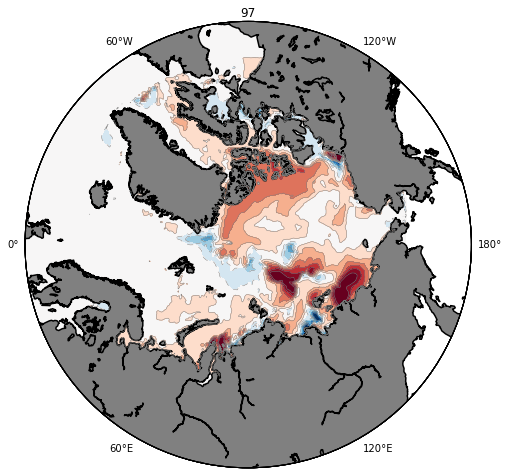

In [119]:
for i in range(7):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    CS = draw_Ba(nav_lon, nav_lat, lower_Ba[i, :, :], clevs, ax, cmap=plt.cm.RdBu_r)
    ax.set_title(str(np.squeeze(lower_ind)[i]))

# EOF to show that "domain-wide increase" is the biggest signal

In [49]:
Ba_EOF = np.transpose(Ba_anom, [1, 2, 0])
EOFs, PC, expvar = EOF(Ba_EOF, nmode=10, ndim=3, reverse=1)

In [57]:
EOFs.shape

(800, 544, 10)

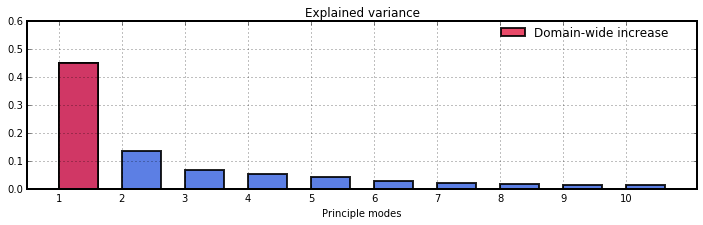

In [105]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM, label='Domain-wide increase')
ax.set_xticks(np.arange(1, 11)); ax.set_ylim(0, 0.6)
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

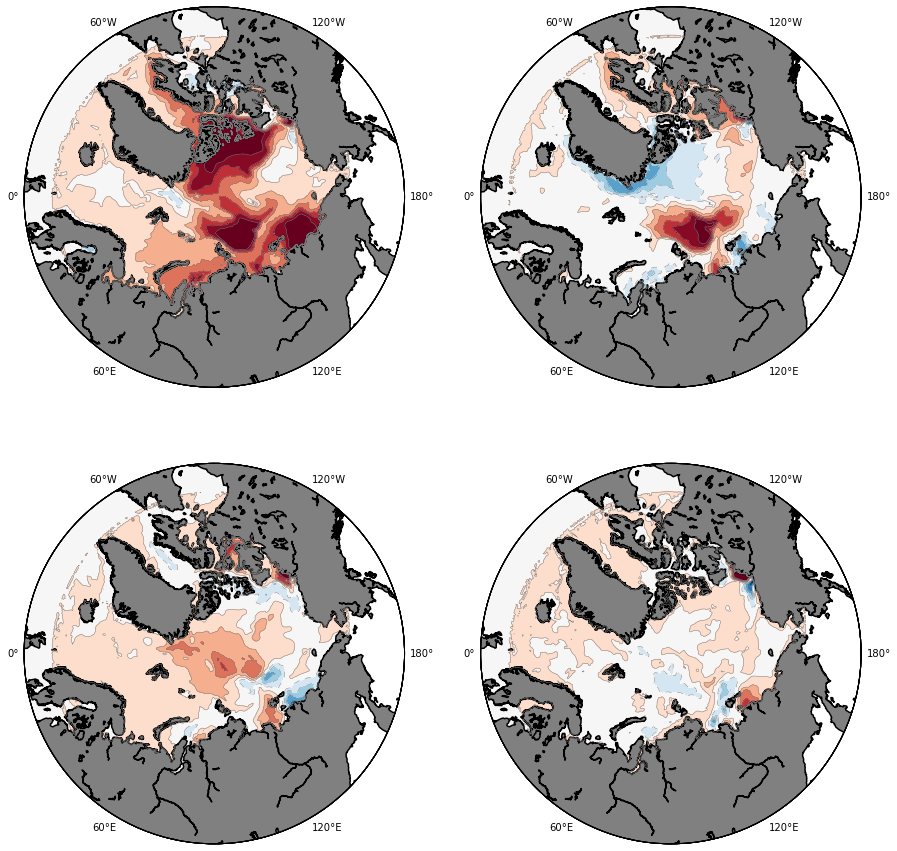

In [78]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)

draw_Ba(nav_lon, nav_lat, EOFs[:, :, 0], clevs/2, ax1, cmap=plt.cm.RdBu_r)
draw_Ba(nav_lon, nav_lat, EOFs[:, :, 1], clevs/2, ax2, cmap=plt.cm.RdBu_r)
draw_Ba(nav_lon, nav_lat, EOFs[:, :, 2], clevs/2, ax3, cmap=plt.cm.RdBu_r)
draw_Ba(nav_lon, nav_lat, EOFs[:, :, 3], clevs/2, ax4, cmap=plt.cm.RdBu_r)

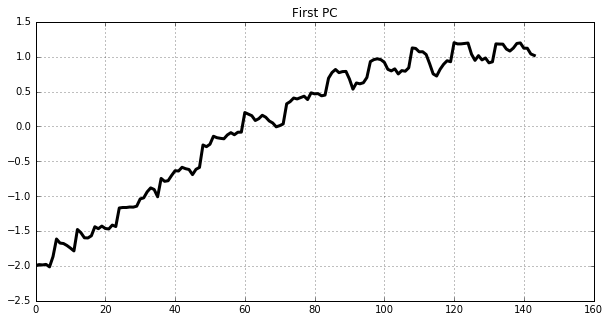

In [104]:
plt.figure(figsize=(10, 5))
ax = plt.gca(); ax.grid()
ax.plot(PC[0, :], 'k-', lw=3)
ax.set_title('First PC')